In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [17]:
# Define a simple neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Load MNIST Data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Initialize network and optimizer
model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Training the network
for epoch in range(10):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} complete")

# Test the network
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        test_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)
print(f"Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)")

Epoch 1 complete
Epoch 2 complete
Epoch 3 complete
Epoch 4 complete
Epoch 5 complete
Epoch 6 complete
Epoch 7 complete
Epoch 8 complete
Epoch 9 complete
Epoch 10 complete
Test set: Average loss: 0.0001, Accuracy: 9762/10000 (98%)


In [25]:
def calculate_ece(probs, labels, n_bins=10):
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    confidences, predictions = torch.max(probs, 1)
    accuracies = predictions.eq(labels)

    ece = torch.zeros(1, device=probs.device)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Find the indices of probabilities that fall into each bin
        in_bin = confidences.gt(bin_lower.item()) & confidences.le(bin_upper.item())
        prop_in_bin = in_bin.float().mean()  # Proportion of data in this bin
        if prop_in_bin.item() > 0:
            # Compute the accuracy of the bin
            accuracy_in_bin = accuracies[in_bin].float().mean()
            # Compute the average confidence of the bin
            avg_confidence_in_bin = confidences[in_bin].mean()
            ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

    return ece.item()

# Example usage:
# Assuming 'model' is your trained model and 'data_loader' is your test data loader
model.eval()
all_probs = torch.tensor([])
all_labels = torch.tensor([])
with torch.no_grad():
    for data, target in test_loader:
        outputs = model(data)
        probs = torch.softmax(outputs, dim=1)
        all_probs = torch.cat((all_probs, probs), dim=0)
        all_labels = torch.cat((all_labels, target), dim=0)

ece = calculate_ece(all_probs, all_labels, 20)
print(f"ECE: {ece}")

ECE: 0.01010993029922247


In [26]:
def calculate_sce(outputs, labels, n_bins=10):
    n_classes = outputs.size(1)
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    sce = torch.zeros(1, device=outputs.device)
    N = outputs.size(0)

    for k in range(n_classes):
        class_probs = outputs[:, k]
        class_labels = labels.eq(k)
        for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
            in_bin = class_probs.gt(bin_lower.item()) & class_probs.le(bin_upper.item())
            nbk = in_bin.sum().item()
            if nbk > 0:
                accuracy_in_bin = class_labels[in_bin].float().mean()
                avg_confidence_in_bin = class_probs[in_bin].mean()
                sce += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * (nbk / N)

    sce /= n_classes
    return sce.item()

# Example usage:
model.eval()
all_outputs = torch.tensor([])
all_labels = torch.tensor([])
with torch.no_grad():
    for data, target in test_loader:
        outputs = model(data)
        all_outputs = torch.cat((all_outputs, outputs), dim=0)
        all_labels = torch.cat((all_labels, target), dim=0)

sce = calculate_sce(all_outputs, all_labels, 20)
print(f"SCE: {sce}")

SCE: 0.040431536734104156


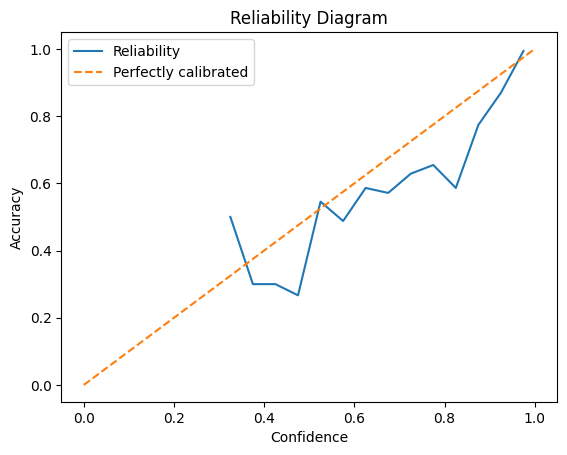

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_reliability_diagram(probs, labels, n_bins=10):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_centers = (bin_boundaries[1:] + bin_boundaries[:-1]) / 2
    confidences, predictions = torch.max(probs, 1)
    accuracies = predictions.eq(labels)

    accuracies_in_bins = np.zeros(n_bins)
    confidences_in_bins = np.zeros(n_bins)
    for i in range(n_bins):
        in_bin = confidences.gt(bin_lowers[i]) & confidences.le(bin_boundaries[i+1])
        accuracies_in_bins[i] = accuracies[in_bin].float().mean().item()
        confidences_in_bins[i] = confidences[in_bin].mean().item()

    plt.plot(bin_centers, accuracies_in_bins, label='Reliability')
    plt.plot([0, 1], [0, 1], '--', label='Perfectly calibrated')
    plt.ylabel('Accuracy')
    plt.xlabel('Confidence')
    plt.title('Reliability Diagram')
    plt.legend()
    plt.show()

# Example usage:
model.eval()
all_probs = torch.tensor([])
all_labels = torch.tensor([])
with torch.no_grad():
    for data, target in test_loader:
        outputs = model(data)
        probs = torch.softmax(outputs, dim=1)
        all_probs = torch.cat((all_probs, probs), dim=0)
        all_labels = torch.cat((all_labels, target), dim=0)

plot_reliability_diagram(all_probs, all_labels, 20)